In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  numpy.linalg as la
import cv2
import os

In [96]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [97]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [98]:
X_train = X_train.reshape(60000,784)
X_test = X_test.reshape(10000,784)
print("Trian data shape : ",X_train.shape)
print("Test data shape : ",X_test.shape)

Trian data shape :  (60000, 784)
Test data shape :  (10000, 784)


In [99]:
def PCA(data,k):
    mean = np.mean(data,axis=0)
    y = data - mean
    print(y.shape)
    y = y.T
    co_var = np.cov(y@y.T)
    eig_values,eig_vectors = la.eigh(co_var)
    sum_ = np.sum(eig_values)
    sort_eig_value_index = np.argsort(eig_values)[::-1][:k]
    eig_values = eig_values[sort_eig_value_index]
    eig_vectors = eig_vectors[sort_eig_value_index]
    #print(eig_values)
    #print(eig_vectors)
    print("% of varience preserved after Dimention Reduction : ",(np.sum(eig_values)/sum_)*100)
    #print(eig_vectors.shape)
    return mean,eig_vectors

In [100]:
def transform_data(mean,Q,data):
    transform_data = Q@(data-mean).T
    transform_data = transform_data.T
    return transform_data

In [101]:
k = 500
mean,eig_vectors = PCA(X_train,k)
print(eig_vectors.shape)

(60000, 784)
% of varience preserved after Dimention Reduction :  99.99997866087503
(500, 784)


In [102]:
transform_train_data = transform_data(mean,eig_vectors,X_train)
print(transform_train_data.shape)
transform_test_data = transform_data(mean,eig_vectors,X_test)
print(transform_test_data.shape)

(60000, 500)
(10000, 500)


In [103]:
class Node :
    def __init__(self,median,dim) -> None:
        self.left = None
        self.right = None
        self.median = median
        self.dim = dim

In [104]:
def KD_Tree(indices,map,labels,data,min_child,max_depth,cur_depth,tag):
    if len(data) <= min_child or cur_depth >= max_depth:
        #print(len(data))
        map[tag] = data
        labels[tag] = indices
        return None

    dim = np.argmax(np.var(data,axis=0))
    median = np.median(data[:,dim])

    condition = data[:,dim] < median

    root = Node(median,dim)

    root.left = KD_Tree(indices[condition],map,labels,data[condition],min_child,max_depth,cur_depth+1,tag+'0')
    root.right = KD_Tree(indices[~condition],map,labels,data[~condition],min_child,max_depth,cur_depth+1,tag+'1')

    return root


In [105]:
map = dict()
labels = dict()
parameters = []
indices = np.arange(len(transform_train_data))
root = KD_Tree(indices,map,labels,transform_train_data,50,15,0,"")

In [106]:
def simillar_images(root,test,tag):
    #print(tag)
    if root == None :
        return tag
    else:
        median = root.median
        dim = root.dim

        if test[dim] < median:
            return simillar_images(root.left,test,tag+'0')
        else:
            return simillar_images(root.right,test,tag+'1')

7
Binary Tag : 11111101000


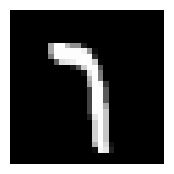

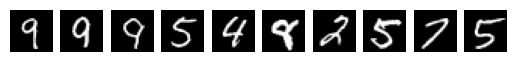

Precision :  0.1


1
Binary Tag : 01100111101


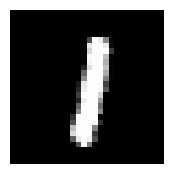

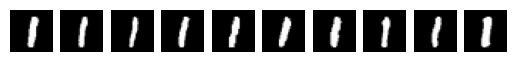

Precision :  1.0


7
Binary Tag : 11001000100


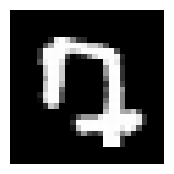

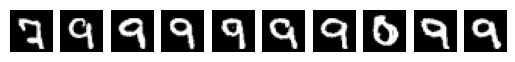

Precision :  0.1


3
Binary Tag : 01000100010


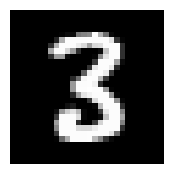

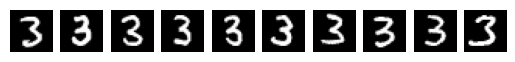

Precision :  1.0


1
Binary Tag : 01111011100


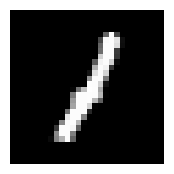

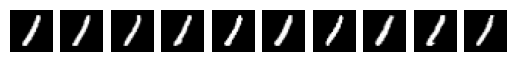

Precision :  1.0


5
Binary Tag : 11010101010


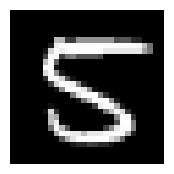

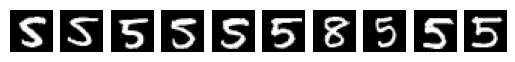

Precision :  0.9


9
Binary Tag : 00010011011


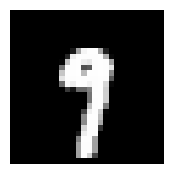

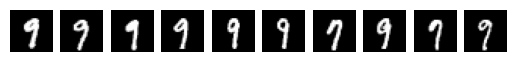

Precision :  0.8


7
Binary Tag : 11100111011


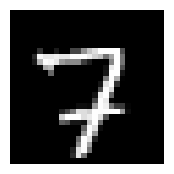

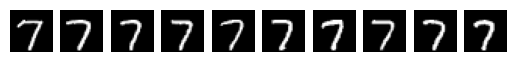

Precision :  1.0


0
Binary Tag : 10000100010


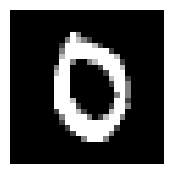

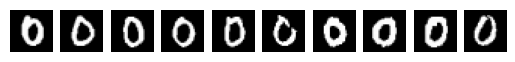

Precision :  1.0


6
Binary Tag : 01101000000


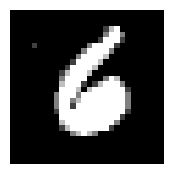

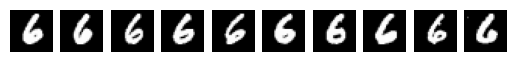

Precision :  1.0


6
Binary Tag : 11001011000


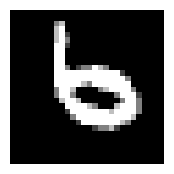

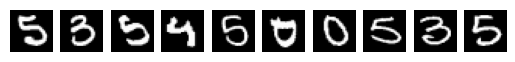

Precision :  0.0


8
Binary Tag : 11010101100


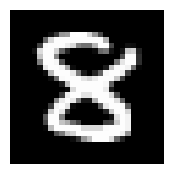

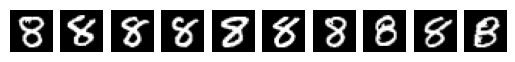

Precision :  1.0


6
Binary Tag : 01111000101


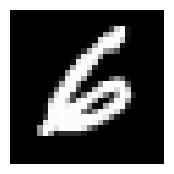

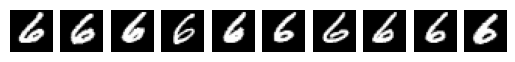

Precision :  1.0


4
Binary Tag : 10111101010


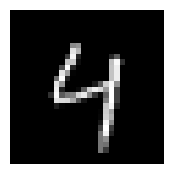

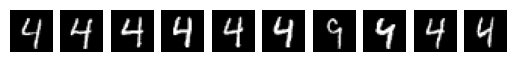

Precision :  0.9


2
Binary Tag : 00000111011


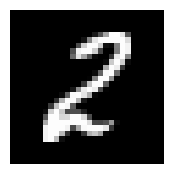

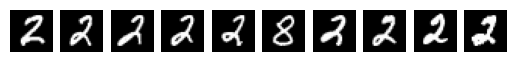

Precision :  0.9




In [107]:
test_indices = np.random.uniform(0,len(transform_test_data),15).astype(int)
#print(list(map.keys()))
Top_k = 10
for index in test_indices:
    res = 0
    plt.figure(figsize = (2,2))
    plt.imshow(X_test_data[index],cmap='gray', vmin=0, vmax=255)
    plt.axis("off")
    digit = Y_test[index]
    print(digit)
    tag,imgs = '',[]
    tag = simillar_images(root,transform_test_data[index],tag)
    print("Binary Tag :",tag)
    test = transform_test_data[index].reshape(-1)

    match_ = map[tag].reshape(-1,len(test))
    for i in np.argsort(la.norm((match_-test),axis = 1))[:Top_k]:
        img_index = labels[tag][i]
        if digit == Y_train[img_index]:
            res+=1
        imgs.append(X_train_data[img_index])
    _, axs = plt.subplots(1,Top_k)
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img,cmap='gray', vmin=0, vmax=255)
        ax.axis("off")
    plt.show()
    print("Precision : ",res/Top_k)
    print("\n")


In [108]:
class Node :
    def __init__(self,mean):
        self.childern = [None]*10
        self.mean = mean

In [109]:
def K_means(K,data,tol):
    labels = np.random.choice(np.arange(K),len(data),replace=True)
    #print(len(labels))
    all_unique_labels = np.unique(labels,return_counts = True)
    #print(all_unique_labels)

    if len(all_unique_labels[0]) != K:
        print("All unique labels not present.")
        return

    mean = []
    for i in range(K):
        mean.append(np.mean(data[np.argwhere(labels == i)],axis=0).reshape(-1))

    mean = np.array(mean)
    #print(mean.shape)
    pre_mean = np.zeros(shape = mean.shape)
    #print(la.norm((pre_mean - mean),axis = 1))
    while np.max(la.norm((pre_mean - mean),axis = 1)) > tol:
        pre_mean = np.copy(mean)
        for i in range(len(data)):
            labels[i] = np.argmin(la.norm((pre_mean - data[i]),axis = 1))

        mean = []
        for i in range(K):
            mean.append(np.mean(data[np.argwhere(labels == i)],axis=0).reshape(-1))
        mean = np.array(mean)
        #print(np.max(la.norm((pre_mean - mean),axis = 1)))
    return mean

In [110]:
def Hier_K_Means(indices,map,labels,data,min_child,max_depth,cur_depth,tag):
    if  len(data) <= min_child or cur_depth >= max_depth:
        map[tag] = data
        labels[tag] = indices
        #print(len(data))
        return None
    means = K_means(10,data,35)
    root = Node(means)
    label = np.zeros(len(data))
    for i in range(len(data)):
            label[i] = np.argmin(la.norm((means - data[i]),axis = 1))
    label = label.astype(int)
    #print(np.unique(label,return_counts=True))

    for k in range(10):
            root.childern[k] = Hier_K_Means(indices[label == k],map,labels,data[label == k],min_child,max_depth,cur_depth+1,tag+str(k))
    return root

In [111]:
map = dict()
labels = dict()
indices = np.arange(len(transform_train_data)).astype(int)
root = Hier_K_Means(indices,map,labels,transform_train_data,500,2,0,"")

In [112]:
len(list(map.keys()))

100

In [113]:
def simillar_images(root,test,tag):
    if root == None:
        return tag
    else:
        means = root.mean
        label = np.argmin(la.norm((means - test),axis = 1))
        return simillar_images(root.childern[label],test,tag+str(label))

7
54


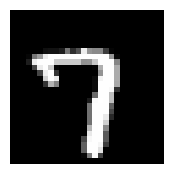

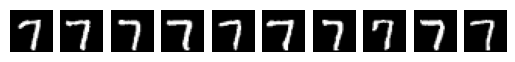

Precision :  1.0


2
80


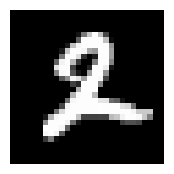

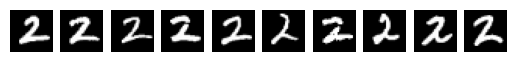

Precision :  1.0


0
18


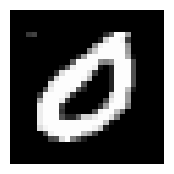

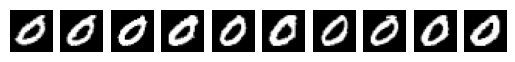

Precision :  1.0


2
80


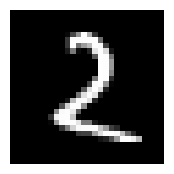

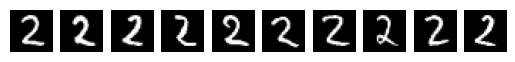

Precision :  1.0


0
14


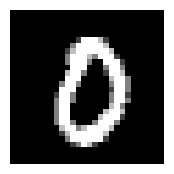

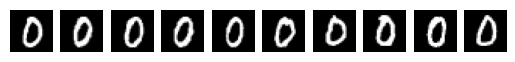

Precision :  1.0


3
82


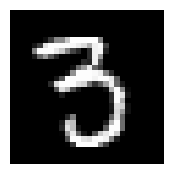

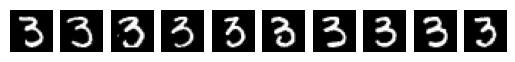

Precision :  1.0


6
24


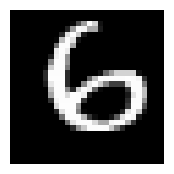

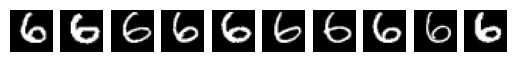

Precision :  1.0


2
43


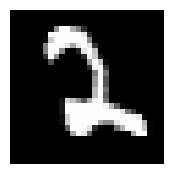

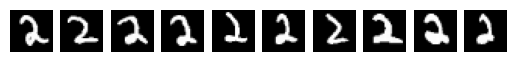

Precision :  1.0


1
39


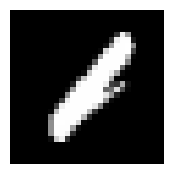

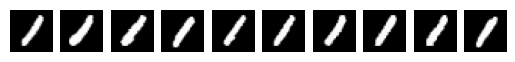

Precision :  1.0


4
35


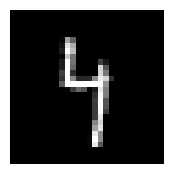

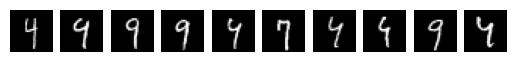

Precision :  0.5




In [114]:
top_K = 10
test_indices = np.random.uniform(0,len(transform_test_data),top_K).astype(int)
for index in test_indices:
    res = 0
    plt.figure(figsize = (2,2))
    plt.imshow(X_test_data[index],cmap="gray",vmin=0,vmax=255)
    plt.axis("off")
    #cv2_imshow(X_test_data[index])
    digit = Y_test[index]
    print(digit)
    tag,imgs = '',[]
    tag = simillar_images(root,transform_test_data[index],tag)
    print(tag)
    test = transform_test_data[index].reshape(-1)
    match_ = map[tag].reshape(-1,len(test))
    for i in np.argsort(la.norm((match_-test),axis = 1))[:top_K]:
        img_index = labels[tag][i]
        if digit == Y_train[img_index]:
            res+=1
        imgs.append(X_train_data[img_index])
    _, axs = plt.subplots(1,Top_k)
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img,cmap='gray', vmin=0, vmax=255)
        ax.axis("off")
    plt.show()
    print("Precision : ",res/top_K)
    print("\n")